In [1]:
import torch
import torchvision
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')

  os.chdir('/content/drive/MyDrive/GitHub/kornia')
except Exception:   # Not run on Google Colab
  import getpass
  if getpass.getuser() == 'vscode':       # Running in container
    os.chdir('/workspaces/kornia/')
  else:                                   # Running in virtual environment
    os.chdir(os.path.join(os.path.expanduser('~'), 'Documents/Git/kornia/'))

print(os.getcwd())
import sys
sys.path.insert(0, os.getcwd())

from kornia.nerf.camera_utils import parse_colmap_output, cameras_for_ids
from kornia.nerf.nerf_solver import NerfSolver
from torchvision.io import read_image
import matplotlib.pyplot as plt
import glob
from typing import List

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/kornia
cuda


## Define scene name and related data directories

In [2]:
# scene_name = 'head_sculpture4'
# scene_name = 'lego'
scene_name = 'flower_4'

data_dir = 'kornia/nerf/kornia_nerf_data/'

scene_dir = os.path.join(data_dir, scene_name)
img_dir = os.path.join(scene_dir, 'images')

print(f'Scene directory: {scene_dir}')

Scene directory: kornia/nerf/kornia_nerf_data/flower_4


## Parse cameras from estimated pos xml

In [3]:
colmap_camera_model_path = os.path.join(scene_dir, 'cameras.txt')
colmap_images_model_path = os.path.join(scene_dir, 'images.txt')

img_names, cameras = parse_colmap_output(
    cameras_path=colmap_camera_model_path, 
    images_path=colmap_images_model_path, 
    device=device,
    dtype=torch.float32, 
    sort_by_image_names=True)

print(cameras.batch_size)
# for i in range(cameras.batch_size):
#   print(f'{img_names[i]}: Intrinsics: \n{cameras.intrinsics[i]}; \nExtrinsics: \n{cameras.extrinsics[i]}')

for img_name in img_names:
  print(img_name)

34
image000.png
image001.png
image002.png
image003.png
image004.png
image005.png
image006.png
image007.png
image008.png
image009.png
image010.png
image011.png
image012.png
image013.png
image014.png
image015.png
image016.png
image017.png
image018.png
image019.png
image020.png
image021.png
image022.png
image023.png
image024.png
image025.png
image026.png
image027.png
image028.png
image029.png
image030.png
image031.png
image032.png
image033.png


### Reparse if .json is found

In [4]:
transforms_json_path = os.path.join(scene_dir, 'transforms_train.json')
if False and os.path.exists(transforms_json_path):
  import json
  import numpy as np
  from kornia.geometry.camera import PinholeCamera

  # img_ext = 'jpeg'
  img_ext = 'png'

  print(f'Parse from .json file at {transforms_json_path}')
  with open(transforms_json_path, 'r') as fp:
    meta = json.load(fp)
  img_names: List[str] = []
  heights: List[int] = []
  widths: List[int] = []
  intrinsics: List[torch.Tensor] = []
  extrinsics: List[torch.Tensor] = []
  for frame in meta['frames']:
    file_path_tmp = frame['file_path']
    img_names.append(f'{os.path.basename(file_path_tmp)}.{img_ext}')
    extrinsics.append(torch.tensor(frame['transform_matrix'], device=device))

    camera_angle_x = float(meta['camera_angle_x'])
    img_path = os.path.join(img_dir, img_names[-1])
    img = read_image(img_path)
    h = img.shape[1]
    w = img.shape[2]
    f = .5 * w / np.tan(.5 * camera_angle_x)
    heights.append(h)
    widths.append(w)
    intrinsic = torch.eye(4, device=device)
    intrinsic[0, 0] = f
    intrinsic[1, 1] = f
    intrinsic[0, 2] = w / 2.
    intrinsic[1, 2] = h / 2.
    intrinsics.append(intrinsic)

  cameras = PinholeCamera(
      torch.stack(intrinsics),
      torch.stack(extrinsics),
      torch.tensor(heights, device=device),
      torch.tensor(widths, device=device),
  )

  print(cameras.batch_size)
  print(cameras.extrinsics[0], type(extrinsics[0]))

## Load training dataset

### Select a subset of images for faster training

In [5]:
num_cams_to_use = 20
if num_cams_to_use != -1:
  random_select = False   # Set for random permutation select
  if random_select:
    camera_ids = torch.randperm(cameras.batch_size)[:num_cams_to_use].tolist()
  else:
    camera_ids = [i for i in range(num_cams_to_use)]
  cameras = cameras_for_ids(cameras, camera_ids)
  img_names = [img_names[i] for i in camera_ids]
print(len(img_names))
for img_name in img_names:
  print(img_name)

20
image000.png
image001.png
image002.png
image003.png
image004.png
image005.png
image006.png
image007.png
image008.png
image009.png
image010.png
image011.png
image012.png
image013.png
image014.png
image015.png
image016.png
image017.png
image018.png
image019.png


### Load images

In [6]:
imgs: List[torch.tensor] = []
for img_name in img_names:
  img_path = os.path.join(img_dir, img_name)
  img = read_image(img_path)
  img = img[:3, ...]    # FIXME: This is a hack until I understand how to work with the alpha channel
  imgs.append(img)
print(len(imgs))

20


image007.png torch.Size([756, 1008, 3])


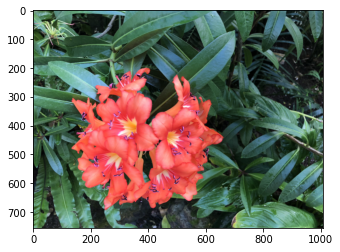

In [7]:
i_plt = 7
img_plt = torch.permute(imgs[i_plt], (1, 2, 0))
plt.imshow(img_plt)
print(img_names[i_plt], img_plt.shape)

### Downsample image and adjust intrinsics

In [8]:
downscale = 2.

if downscale > 1:
  height = int(imgs[0].shape[1] / downscale)
  width = int(imgs[0].shape[2] / downscale)
  transform = torchvision.transforms.Resize((height, width))

  for i, img in enumerate(imgs):
      img = transform(img)
      if img.shape[0] == 4: # Convert RGBA to RGB
        img = kornia.color.rgba_to_rgb(img / 255.)
        img = (img * 255.).to(torch.uint8)
      imgs[i] = img

  cameras = cameras.scale(1. / downscale)

  print(imgs[0].shape)

  print(cameras.batch_size)
  # for i in range(cameras.batch_size):
  #   print(f'Intrinsics: \n{cameras.intrinsics[i]}; \nExtrinsics: \n{cameras.extrinsics[i]}')

torch.Size([3, 378, 504])
20


## Run training on image scene

In [ ]:
nerf_obj = NerfSolver(device=device, dtype=torch.float32)
num_img_rays = 128
batch_size = 4096

nerf_obj.init_training(cameras=cameras, min_depth=2., max_depth=60., ndc=False, imgs=imgs, num_img_rays=num_img_rays, 
                       batch_size=batch_size, num_ray_points=256, irregular_ray_sampling=True)

# torch.manual_seed(0)    # For reproducibility of random processes

nerf_obj.run(num_epochs=10000)

Epoch: 0: epoch_psnr = 10.895051002502441; time: 01:42:50
Epoch: 10: epoch_psnr = 12.803018569946289; time: 01:42:59


In [ ]:
# nerf_obj.run(num_epochs=10000)

## Rendering novel views

### Sub-set of input cameras

In [ ]:
from kornia.nerf.camera_utils import cameras_for_ids

camera_ids = [0]
cameras_to_render = cameras_for_ids(cameras, camera_ids)

In [ ]:
imgs_rendered = nerf_obj.render_views(cameras_to_render)

In [ ]:
plt.imshow(imgs_rendered[0])

### Spline path pattern

### Spiral pattern

In [ ]:
from kornia.nerf.camera_utils import create_spline_curve, create_spiral_path

# cameras_spline_path = create_spline_curve(cameras, 60)

cameras_spline_path = create_spiral_path(cameras, rad=1., num_views=60, num_circles=2)

imgs_rendered_spline_path = nerf_obj.render_views(cameras_spline_path)

### Create movie for output pattern

In [ ]:
import numpy as np
import imageio

imgs_rendered_spline_path_numpy = [img_rendered_spline_path.cpu().numpy() for img_rendered_spline_path in imgs_rendered_spline_path]

gif_path = os.path.join(scene_dir, scene_name + '_spline_path.gif')
imageio.mimwrite(gif_path, imgs_rendered_spline_path_numpy, fps=30)

In [ ]:
from IPython.display import Image
Image(open(gif_path, 'rb').read())